In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt




/var/folders/hv/1_92kz110w572ncggsb_c81c0000gp/T/ipykernel_90805/3568035392.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was too old on your system - pyarrow 10.0.1 is the current minimum supported version as of this release.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
class NelsonSiegelSvensson:
    def __init__(self, df, n_max) -> None:
        self.df = df
        self.n_max = n_max  
          
    @staticmethod
    def nelson_siegel(n, tau1, beta0, beta1, beta2, beta3: float = 0, tau2 : float = 0):
        part1 = beta0
        part2 = beta1 * (1 - math.exp(-n / tau1)) / (n / tau1)  # beta1 * (1- math.exp(-n/tau1)) / (n / tau1)
        part3 = beta2 * (((1 - math.exp(-n / tau1)) / (n / tau1)) - math.exp(
            -n / tau1))  # beta2 *(((1- math.exp(-n/tau1)) / (n / tau1))  - math.exp(-n / tau1))
        part4 = beta3 * (((1 - math.exp(-n / tau2)) / (n / tau2)) - math.exp(-n / tau2))
        total = part1 + part2 + part3 + part4

        return [part1, part2, part3, part4, total]

    def get_curve(self, tau1, beta0, beta1, beta2, beta3, tau2, n_range):
        """

        Args:
            tau1 (_type_): _description_
            beta0 (_type_): _description_
            beta1 (_type_): _description_
            beta2 (_type_): _description_
            n_range (_type_): _description_
            
        Output : 1 x n_range
        
        """
        result = np.zeros(n_range-1)
        part1 = np.zeros(n_range-1)
        part2 = np.zeros(n_range-1)
        part3 = np.zeros(n_range-1)
        part4 = np.zeros(n_range - 1)
        for n in range(1, n_range):
            n_step = n/12
            part1[n-1], part2[n-1], part3[n-1], part4[n-1], result[n-1] = self.nelson_siegel(n_step, tau1, beta0, beta1, beta2, beta3, tau2)
        return (part1, part2, part3, part4, result)


    def plot_curve(self):
        if len(self.df) < 6:
            beta0, beta1, beta2, tau1  = self.df
            beta3 = 0
            tau2 = 1
        else:
            beta0, beta1, beta2, beta3, tau1, tau2  = self.df
        
        part1, part2, part3, part4, result = self.get_curve(tau1, beta0, beta1, beta2, beta3, tau2, self.n_max)
        time_steps = np.arange(1, self.n_max) / 12 
        # Plot each curve
        
        
        plt.figure(figsize=(10, 6))  # Create a new figure for each plot
        plt.plot(time_steps, result, label=f'Yield Curve')
        plt.title(f'Nelson-Siegel Yield Curve')
        plt.xlabel('Time (Years)')
        plt.ylabel('Nelson-Siegel Result')
        plt.legend()
        plt.show()
        
        
        plt.figure(figsize=(10, 6))
        plt.plot(time_steps, part1, label = "Equilibrium")
        plt.plot(time_steps, part2, label = "Beta1")
        plt.plot(time_steps, part3, label = "Beta2")
        plt.plot(time_steps, part4, label="Beta3")
        plt.title(f'Décomposition Nelson-Siegel Yield Curve')
        plt.xlabel('Time (Years)')
        plt.ylabel('Nelson-Siegel Result')
        plt.legend()
        plt.show()


        
        

## Parameters of Nelson-Siegel Yield Curve

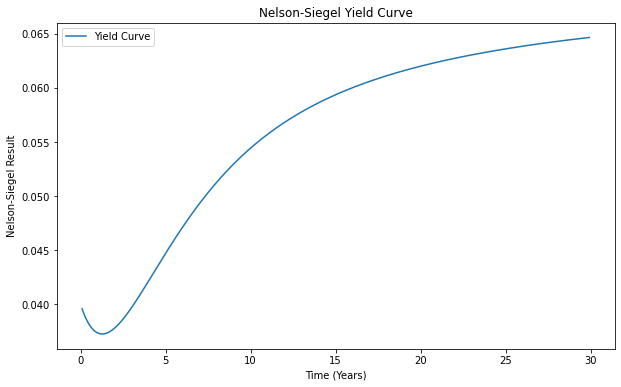

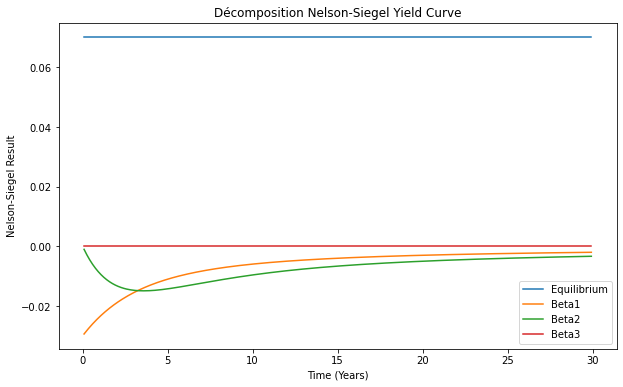

In [3]:
n_max = 30 * 12
# Define the data
data = {
    'beta0': [0.07, 0.07, 0.07, 0, 0, 0, 0.07],
    'beta1': [-0.03, 0.03, -0.03, 0, 0, 0, -0.03],
    'beta2': [0, 0, 0, -0.05, 0.05, -0.05, -0.05],
    'tau1': [2, 2, 9, 2, 2, 9, 2]
}

i = 6
data_params = [data[label][i] for label in list(data.keys())]
beta0, beta1, beta2, tau1  = data_params

obj = NelsonSiegelSvensson(data_params, n_max)
obj.plot_curve()

In [4]:
# Creating the requested DataFrame
data = {
    'YTM': [0.039475, 0.042226, 0.043471, 0.044637, 0.047257, 0.044753],
    'TTM': [2, 4, 6, 9, 18, 30]
}

df_ytm_ttm = pd.DataFrame(data)

df_ytm_ttm

,YTM,TTM
0,0.039475,2
1,0.042226,4
2,0.043471,6
3,0.044637,9
4,0.047257,18
5,0.044753,30


In [5]:
# Objective function to minimize
from scipy.optimize import minimize

# Create function
class Exercice2:
    def __init__(self, mode_Nelson : bool = True):
        self.mode = mode_Nelson
    
    def nelsonsiegel(self, n, beta0, beta1, beta2, tau1):

        return beta0 + beta1 * (1- math.exp(-n/tau1)) / (n / tau1) + beta2 *(((1- math.exp(-n/tau1)) / (n / tau1))  - math.exp(-n / tau1))
    
    def svensson(self, n, beta0, beta1, beta2, beta3, tau1, tau2):

        return beta0 + beta1 * (1- math.exp(-n/tau1)) / (n / tau1) + beta2 *(((1- math.exp(-n/tau1)) / (n / tau1))  - math.exp(-n / tau1)) + beta3 *(((1- math.exp(-n/tau2)) / (n / tau2))  - math.exp(-n / tau2))
        
    def objective_function(self, params, ytm, ttm):
        if self.mode:
            beta0, beta1, beta2, tau1 = params
            predicted_ytm = np.array([self.nelsonsiegel(n, beta0, beta1, beta2, tau1) for n in ttm])
            return np.sum((ytm - predicted_ytm) ** 2)
        
        else:
            beta0, beta1, beta2, beta3, tau1, tau2 = params
            
            predicted_ytm = np.array([self.svensson(n, beta0, beta1, beta2, beta3, tau1, tau2) for n in ttm])
            return np.sum((ytm - predicted_ytm) ** 2)
    
    def main(self, ytm_data, ttm_data):
                # Initial guesses for parameters
        if self.mode:
            initial_params = [0.03, -0.02, 0.01, 1]  # These are just example initial guesses
        else:
            initial_params = [0.03, -0.02, 0.01, 1, 0.3, 0.2]  # These are just example initial guesses
        # Run the optimization
        result = minimize(self.objective_function, initial_params, args=(ytm_data, ttm_data))
        
        return result


## Exercice 2 - Paramètre estimé 

[0.04669028731685836, -0.01323118559445018, -0.005079839663306477, 0.9999378291016418]


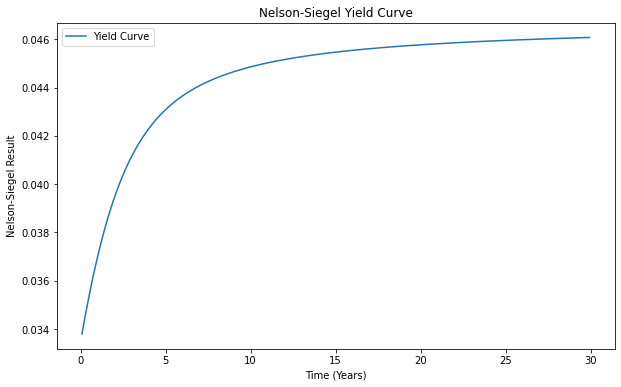

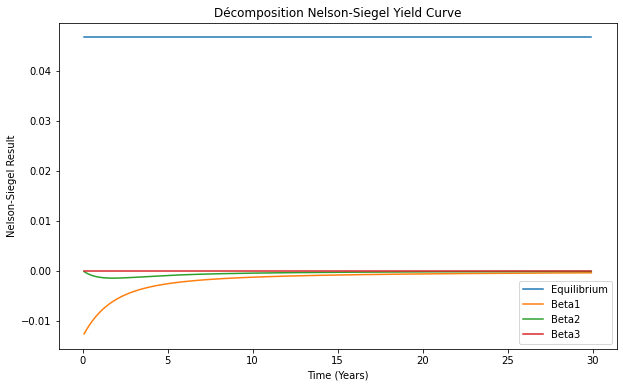

In [10]:
# Creating the requested DataFrame
data = {
    'YTM': [0.039475, 0.042226, 0.043471, 0.044637, 0.047257, 0.044753],
    'TTM': [2, 4, 6, 9, 18, 30]
}

df_ytm_ttm = pd.DataFrame(data)

# YTM and TTM data from your DataFrame
ytm_data = df_ytm_ttm['YTM'].values
ttm_data = df_ytm_ttm['TTM'].values


# Run the optimization
result = Exercice2(mode_Nelson=True)
l = result.main(ytm_data, ttm_data)
# The optimal parameters
df = [x for x in l.x] 
print(df)
obj = NelsonSiegelSvensson(df, n_max)
obj.plot_curve()

Text(0, 0.5, 'Yield to Maturity')

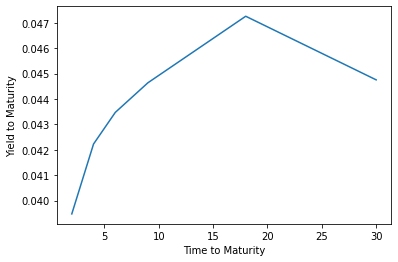

In [8]:
# Plotting the data
plt.plot(ttm_data, ytm_data)  # Note: positional arguments, not keywords

# Labeling the axes
plt.xlabel('Time to Maturity')
plt.ylabel('Yield to Maturity')

## Exercice 3 - À l'aide des prix
